# AWS

## Deployment Pipeline

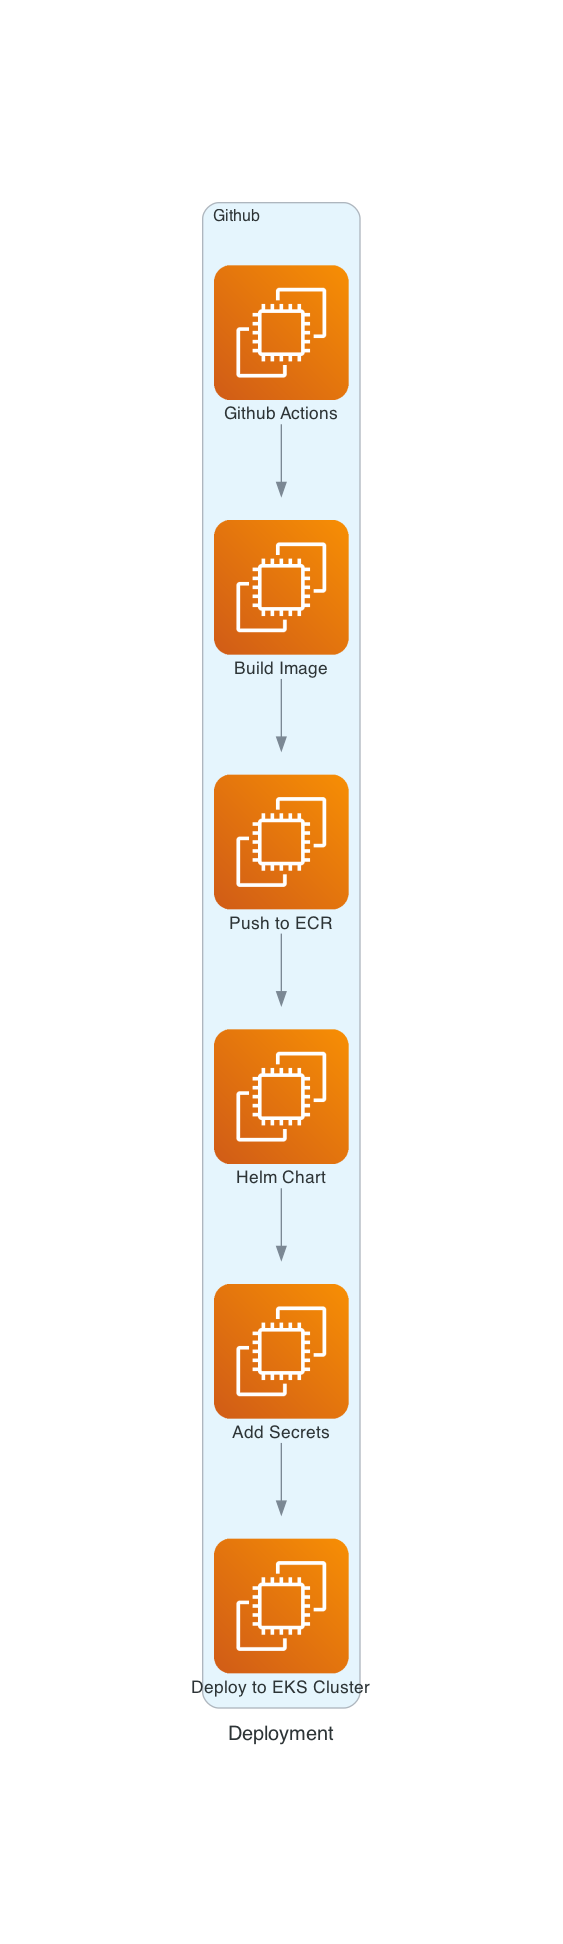

In [1]:
#!/usr/bin/env python3

from diagrams import Diagram, Cluster
from diagrams.aws.compute import EC2

with Diagram("Deployment", show=False, direction="TB") as diag:
    with Cluster("Github"):
        EC2("Github Actions") >> EC2("Build Image") >> EC2("Push to ECR") >> EC2("Helm Chart") >> EC2("Add Secrets") >> EC2("Deploy to EKS Cluster")

diag


## Cloud Infrastructure

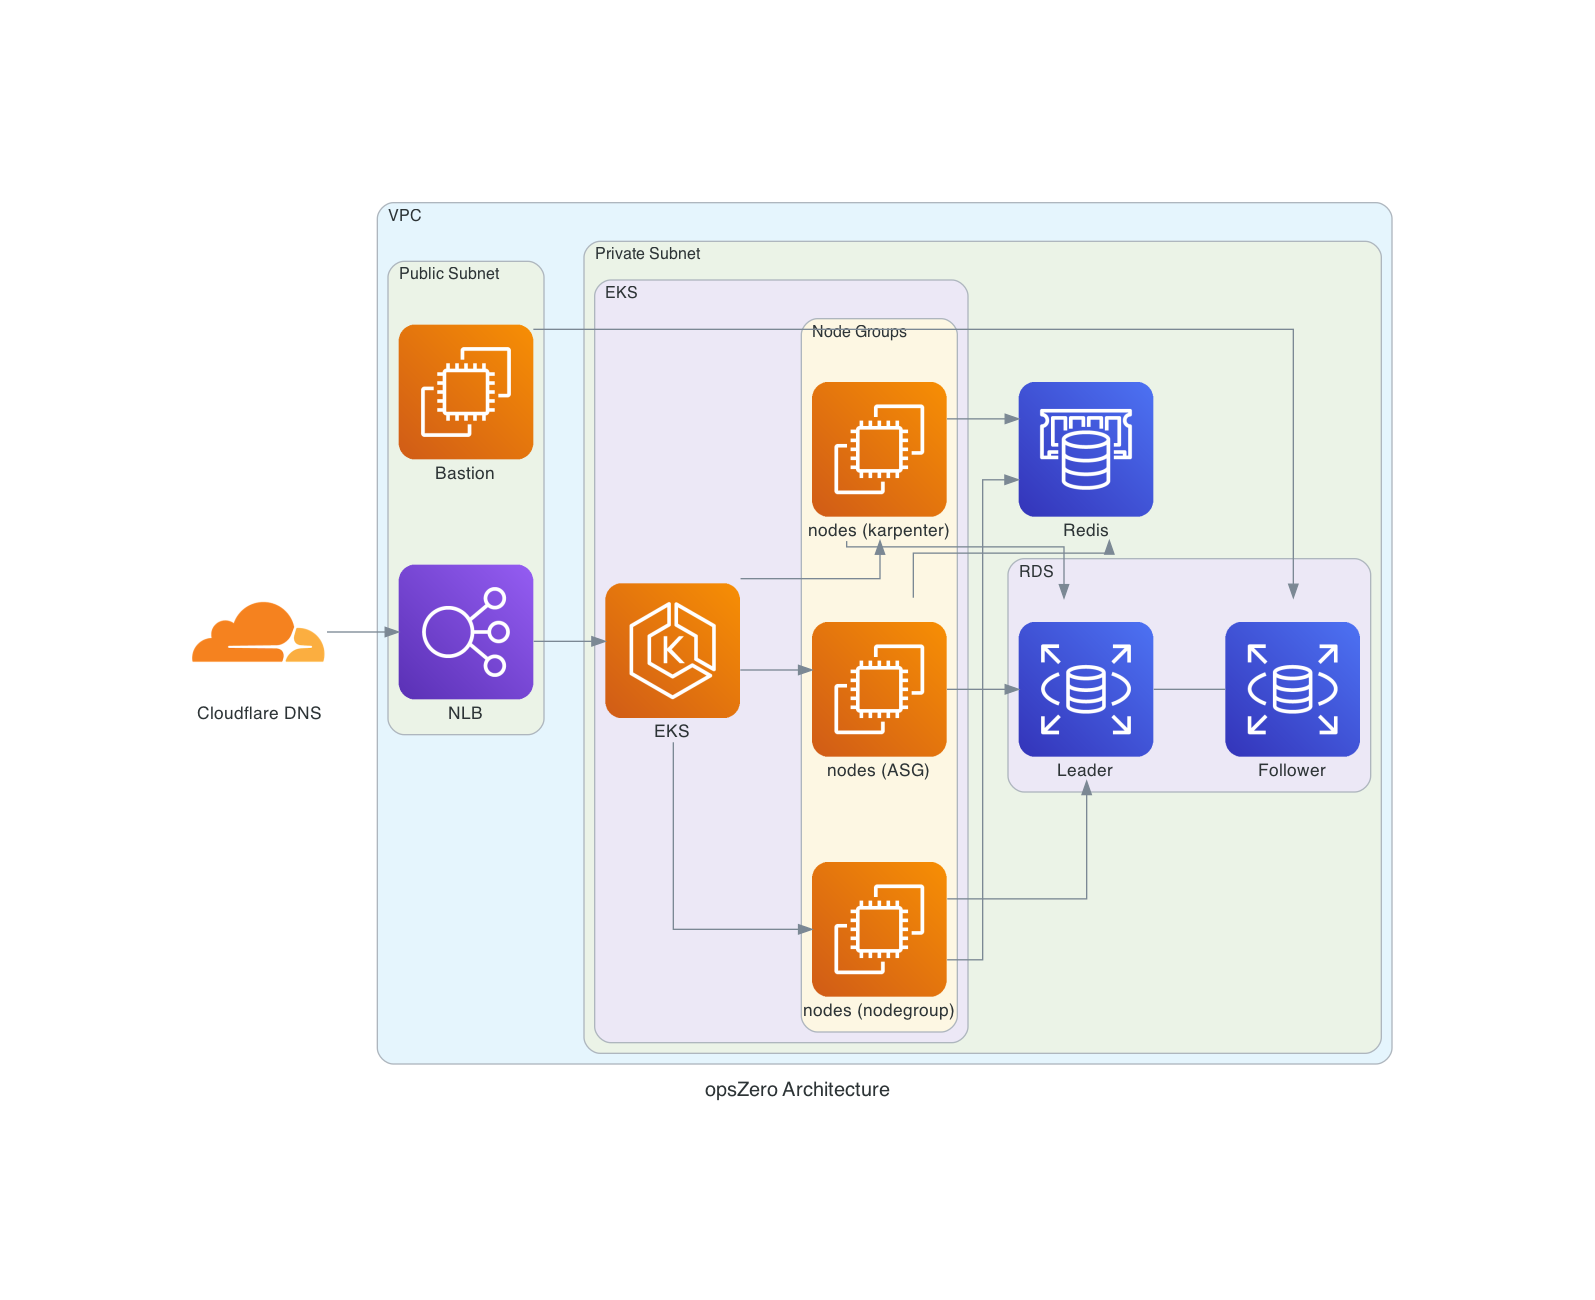

In [2]:
#!/usr/bin/env python

from diagrams import Cluster, Diagram
from diagrams.aws.database import RDS, ElastiCache
from diagrams.aws.network import ELB, Route53
from diagrams.aws.compute import EC2, ElasticKubernetesService
from diagrams.saas.cdn import Cloudflare


with Diagram("opsZero Architecture", show=False) as diag:
    dns = Cloudflare("Cloudflare DNS")

    with Cluster("VPC"):
        with Cluster("Public Subnet"):
            lb = ELB("NLB")

            bastion = EC2("Bastion")

        with Cluster("Private Subnet"):
            with Cluster("EKS"):
                eks = ElasticKubernetesService("EKS")
                with Cluster("Node Groups"):
                    svc_group = [
                        EC2("nodes (nodegroup)"),
                        EC2("nodes (karpenter)"),
                        EC2("nodes (ASG)")
                    ]

            with Cluster("RDS"):
                db_master = RDS("Leader")
                db_follower = RDS("Follower")
                db_master - [db_follower]

            redis = ElastiCache("Redis")

    

    dns >> lb >> eks >> svc_group
    bastion >> db_follower
    svc_group >> db_master
    svc_group >> redis

diag

## Kubernetes

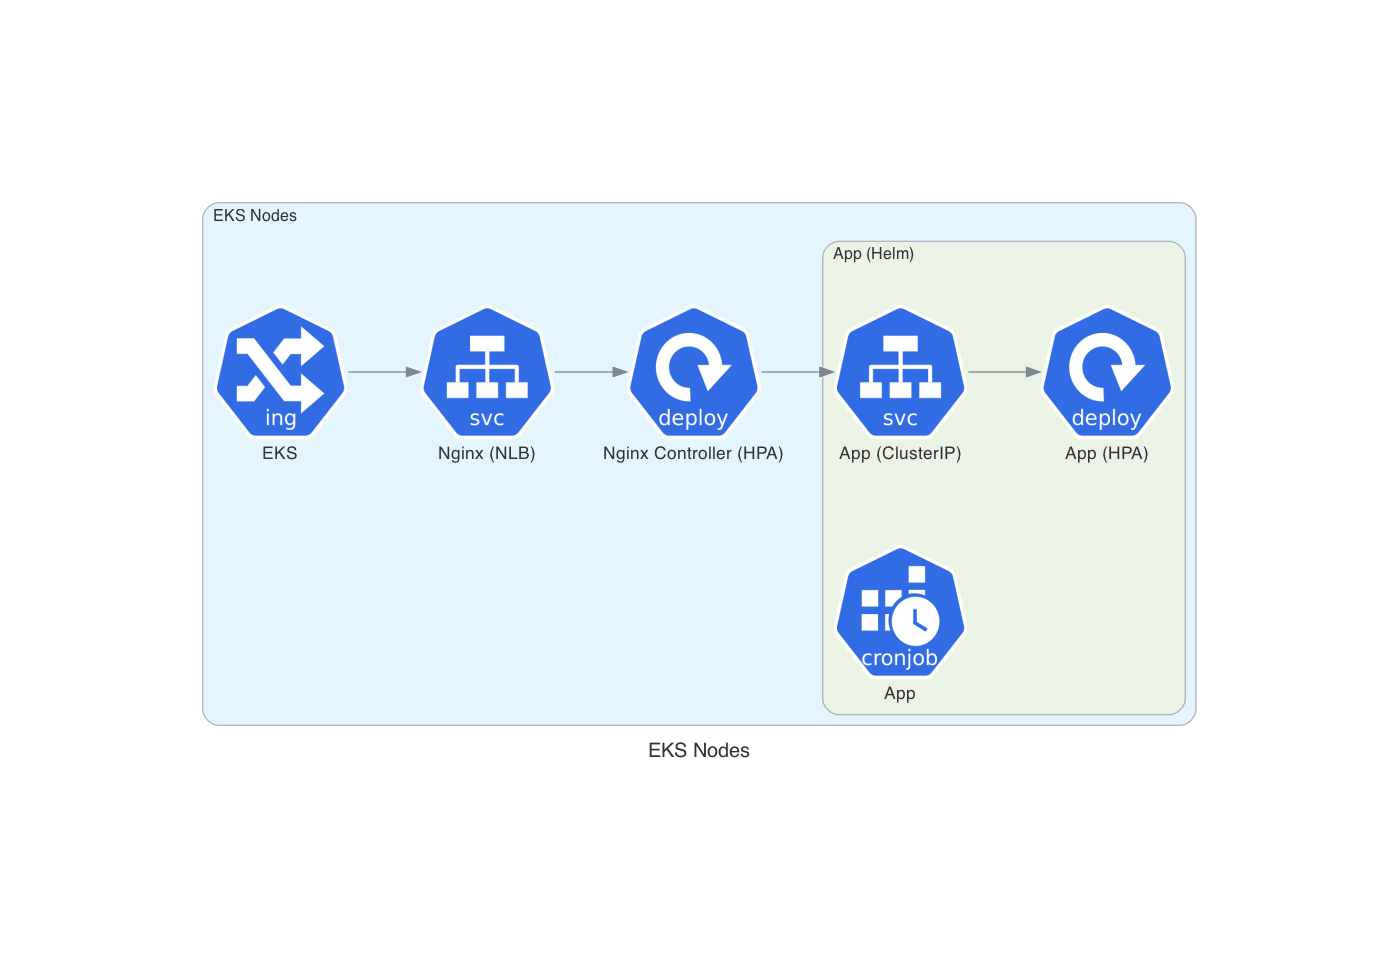

In [3]:
#!/usr/bin/env python

from diagrams import Cluster, Diagram
from diagrams.k8s.clusterconfig import HPA
from diagrams.k8s.compute import Deployment, Pod, ReplicaSet, Cronjob
from diagrams.k8s.network import Ingress, Service

with Diagram("EKS Nodes", show=False) as diag:
    with Cluster("EKS Nodes"):
        net = Ingress("EKS") >> Service("Nginx (NLB)") >> Deployment("Nginx Controller (HPA)")

        with Cluster("App (Helm)"):
            net >> Service("App (ClusterIP)") >> [
                Deployment("App (HPA)"),
            ]
            Cronjob("App")

diag